# Analyzing Healthcare Provider Shortage - Part 1/3

America has a __severe shortage__ of healthcare providers. According to a recent [article](https://thehill.com/opinion/healthcare/447923-there-is-a-severe-physician-shortage-and-it-will-only-worsen) in The Hill, the country faces a severe physician workforce shortage. 
 - Demand for services is increasing 
 - Shortages of physicians and mental health providers are limiting patients’ access to required treatment. 

According to a 2019 [study](https://news.aamc.org/press-releases/article/2019-workforce-projections-update/) conducted by the Association of American Medical Colleges (AAMC), by the year 2032, the United States will see a shortage of up to nearly 122,000 physicians. A shortfall of roughly 25,000 to 66,000 specialists and 21,000 to 55,000 primary care physicians.

<img src="ProviderShortage.jpg">
Image source: https://blog.medicaresolutions.com/the-u-s-doctor-shortage/

In this study, we will use National Plan and Provider Enumeration System (NPPES) [healthcare provider data](https://www.cms.gov/Regulations-and-Guidance/Administrative-Simplification/NationalProvIdentStand/DataDissemination.html) to identify shortage areas for physicians and mental healthcare providers in the U.S. We will also predict and identify new locations for providers to setup shop in shortage areas.

## Part 1: Provider Shortage - Data Preparation

In this notebook, we will:
- Read large data file (~6GB) using Dask
- Clean the data by:
    - dropping existing columns
    - adding new columns
    - renaming columns
    - change categories of a column
    - change data types
- Compute data using dask
- Basic exploration and missing value determination
- Export data into multiple csv files

## Getting the Data

The latest Healthcare Provider data file can be downloaded from [NPPES](https://www.cms.gov/Regulations-and-Guidance/Administrative-Simplification/NationalProvIdentStand/DataDissemination.html). For our analysis, we willl use the file from May 2019. The dataset contains ~5.8 million records with 329 attributes; 6.7GB on disk.
It includes healthcare provider information such as:
 - Organization Name, Address, National Provider Identifier, Gender, Entity Type
 - Taxonomy codes that define provider type, classification and area of specialization​


In [1]:
# Import Libraries

# Import Dask for reading and processing big data
import dask.dataframe as dd

# Import Pandas for data exploration
import pandas as pd
pd.set_option('display.max_columns', 500)

# Import plotting libraries
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# Import libraries for time and output
import time
import os

# Import arcgis
import arcgis
from arcgis.gis import GIS
from arcgis.geocoding import batch_geocode, geocode

In [2]:
# Create GIS connection

# gis = GIS("https://www.arcgis.com","arcgis_python","P@ssword123")

## Read the Data: Using Dask

Sheer size of this data does not allow for exploration using basic tools like Excel or Pandas. Traditional packages such as Pandas cannot be used as they expect data to fit fully in memory and are not designed to scale beyond a single machine.

Thus, in this part of the study, we will use [DASK](https://docs.dask.org/en/latest/#), a distributed data analysis library. Dask enables efficient parallel computations on single machines by leveraging their multi-core CPUs and streaming data efficiently from disk. Dask provides a DataFrame object that mimics traditional pandas DataFrame which can be used to perform operations to slice, dice the data and do explorations. However, transformative operations on the DataFrame get queued and are operated only when necessary. When executed, Dask will read data in chunks, distribute it (be it cores on a single machine or multiple machines in a cluster set up) and compute the data for you. Thus, DASK allows us to work with any larger than memory dataset as it performs operations on chunks in a distributed manner.

We will read the data as a dask dataframe and review the attributes

In [2]:
# Read the data as dask dataframe

npi_data = dd.read_csv('npidata.csv', blocksize=1000000, dtype=str)

In [3]:
# Confirm type of dataset
type(npi_data)

dask.dataframe.core.DataFrame

In [20]:
npi_data.head()

,NPI,Entity Type Code,Replacement NPI,Employer Identification Number (EIN),Provider Organization Name (Legal Business Name),Provider Last Name (Legal Name),Provider First Name,Provider Middle Name,Provider Name Prefix Text,Provider Name Suffix Text,Provider Credential Text,Provider Other Organization Name,Provider Other Organization Name Type Code,Provider Other Last Name,Provider Other First Name,Provider Other Middle Name,Provider Other Name Prefix Text,Provider Other Name Suffix Text,Provider Other Credential Text,Provider Other Last Name Type Code,Provider First Line Business Mailing Address,Provider Second Line Business Mailing Address,Provider Business Mailing Address City Name,Provider Business Mailing Address State Name,Provider Business Mailing Address Postal Code,Provider Business Mailing Address Country Code (If outside U.S.),Provider Business Mailing Address Telephone Number,Provider Business Mailing Address Fax Number,Provider First Line Business Practice Location Address,Provider Second Line Business Practice Location Address,Provider Business Practice Location Address City Name,Provider Business Practice Location Address State Name,Provider Business Practice Location Address Postal Code,Provider Business Practice Location Address Country Code (If outside U.S.),Provider Business Practice Location Address Telephone Number,Provider Business Practice Location Address Fax Number,Provider Enumeration Date,Last Update Date,NPI Deactivation Reason Code,NPI Deactivation Date,NPI Reactivation Date,Provider Gender Code,Authorized Official Last Name,Authorized Official First Name,Authorized Official Middle Name,Authorized Official Title or Position,Authorized Official Telephone Number,Healthcare Provider Taxonomy Code_1,Provider License Number_1,Provider License Number State Code_1,Healthcare Provider Primary Taxonomy Switch_1,Healthcare Provider Taxonomy Code_2,Provider License Number_2,Provider License Number State Code_2,Healthcare Provider Primary Taxonomy Switch_2,Healthcare Provider Taxonomy Code_3,Provider License Number_3,Provider License Number State Code_3,Healthcare Provider Primary Taxonomy Switch_3,Healthcare Provider Taxonomy Code_4,Provider License Number_4,Provider License Number State Code_4,Healthcare Provider Primary Taxonomy Switch_4,Healthcare Provider Taxonomy Code_5,Provider License Number_5,Provider License Number State Code_5,Healthcare Provider Primary Taxonomy Switch_5,Healthcare Provider Taxonomy Code_6,Provider License Number_6,Provider License Number State Code_6,Healthcare Provider Primary Taxonomy Switch_6,Healthcare Provider Taxonomy Code_7,Provider License Number_7,Provider License Number State Code_7,Healthcare Provider Primary Taxonomy Switch_7,Healthcare Provider Taxonomy Code_8,Provider License Number_8,Provider License Number State Code_8,Healthcare Provider Primary Taxonomy Switch_8,Healthcare Provider Taxonomy Code_9,Provider License Number_9,Provider License Number State Code_9,Healthcare Provider Primary Taxonomy Switch_9,Healthcare Provider Taxonomy Code_10,Provider License Number_10,Provider License Number State Code_10,Healthcare Provider Primary Taxonomy Switch_10,Healthcare Provider Taxonomy Code_11,Provider License Number_11,Provider License Number State Code_11,Healthcare Provider Primary Taxonomy Switch_11,Healthcare Provider Taxonomy Code_12,Provider License Number_12,Provider License Number State Code_12,Healthcare Provider Primary Taxonomy Switch_12,Healthcare Provider Taxonomy Code_13,Provider License Number_13,Provider License Number State Code_13,Healthcare Provider Primary Taxonomy Switch_13,Healthcare Provider Taxonomy Code_14,Provider License Number_14,Provider License Number State Code_14,Healthcare Provider Primary Taxonomy Switch_14,Healthcare Provider Taxonomy Code_15,Provider License Number_15,Provider License Number State Code_15,Healthcare Provider Primary Taxonomy Switch_15,Other Provider Identifier_1,Other Provider Identifier Type Code_1,Other Provider Ide

In [5]:
len(npi_data.columns)

329

We can see that the dataset is pretty wide with 329 attributes. We can classify the attributes of this dataset as:
 - Provider Details - this includes items like:
     - National Provider Identifier (NPI) which is a unique identifier
     - Name, Gender, Credential, Provider License No., Employer Identification Number (EIN), Entity Type (Individual/Org)
     - Address and Phone No. details for both mailing and practice location addresses 
     
     
 - Provider License and Speciality Details - this includes items like:
     - Taxonomy Code, Taxonomy Group, Taxonomy Switch - these identify the speciality of a provider
     - Provider Identifier/type/state/issuer columns
     - License No., License No. State Codes for each state for which provider holds a license

## Clean the Data

We will clean the data by removing unnecessary attributes. We will rename the remaining attributes and filter data for United States. We will also create a new `full_address` attribute combining by various address fields and change the categories for `entity_type`.

### Drop Columns

For our analysis, we will remove a majority of the attirbutes keeping only 26 attributes that are of value to us.

In [21]:
# # Identify columns to keep
# cols_to_keep = ['NPI','Entity Type Code', 'Healthcare Provider Taxonomy Code_1', 'Healthcare Provider Taxonomy Code_2',\
#                    'Healthcare Provider Taxonomy Code_3','Healthcare Provider Taxonomy Code_4', 'Healthcare Provider Taxonomy Code_5',\
#                    'Healthcare Provider Taxonomy Code_6','Healthcare Provider Taxonomy Code_7','Healthcare Provider Taxonomy Code_8',\
#                    'Healthcare Provider Taxonomy Code_9','Healthcare Provider Taxonomy Code_10','Healthcare Provider Taxonomy Code_11',\
#                    'Healthcare Provider Taxonomy Code_12','Healthcare Provider Taxonomy Code_13','Healthcare Provider Taxonomy Code_14',\
#                     'Healthcare Provider Taxonomy Code_15','Healthcare Provider Taxonomy Group_1',\
#                     'Provider Gender Code','Provider Organization Name (Legal Business Name)',\
#                     'Provider First Line Business Practice Location Address',\
#                    'Provider Second Line Business Practice Location Address','Provider Business Practice Location Address City Name',\
#                     'Provider Business Practice Location Address State Name','Provider Business Practice Location Address Country Code (If outside U.S.)',\
#                    'Provider Business Practice Location Address Postal Code']

# Identify columns to keep
cols_to_keep = ['NPI','Entity Type Code', 'Healthcare Provider Taxonomy Code_1','Healthcare Provider Taxonomy Group_1',\
                    'Provider Gender Code','Provider Organization Name (Legal Business Name)',\
                    'Provider First Line Business Practice Location Address',\
                   'Provider Second Line Business Practice Location Address','Provider Business Practice Location Address City Name',\
                    'Provider Business Practice Location Address State Name','Provider Business Practice Location Address Country Code (If outside U.S.)',\
                   'Provider Business Practice Location Address Postal Code']

In [22]:
# Get columns to drop
all_columns = set(npi_data.columns)
cols_to_keep_set = set(cols_to_keep)
cols_to_drop = all_columns - cols_to_keep_set

In [23]:
# Check length 
len(all_columns), len(cols_to_keep_set), len(cols_to_drop)

(329, 12, 317)

In [24]:
# Drop columns
#npi_updated = npi_data.loc[:,cols_to_keep]
npi_updated = npi_data.drop(list(cols_to_drop), axis=1)

In [25]:
npi_updated.head()

,NPI,Entity Type Code,Provider Organization Name (Legal Business Name),Provider First Line Business Practice Location Address,Provider Second Line Business Practice Location Address,Provider Business Practice Location Address City Name,Provider Business Practice Location Address State Name,Provider Business Practice Location Address Postal Code,Provider Business Practice Location Address Country Code (If outside U.S.),Provider Gender Code,Healthcare Provider Taxonomy Code_1,Healthcare Provider Taxonomy Group_1
0,1679576722,1,NaN,3500 CENTRAL AVE,NaN,KEARNEY,NE,688472944,US,M,207X00000X,NaN
1,1588667638,1,NaN,1824 KING STREET,SUITE 300,JACKSONVILLE,FL,322044736,US,M,207RC0000X,NaN
2,1497758544,2,"CUMBERLAND COUNTY HOSPITAL SYSTEM, INC",3418 VILLAGE DR,NaN,FAYETTEVILLE,NC,283044552,US,NaN,251G00000X,NaN
3,1306849450,1,NaN,810 LUCAS DR,NaN,ATHENS,TX,757513446,US,M,2085R0202X,NaN
4,1215930367,1,NaN,17323 RED OAK DR,NaN,HOUSTON,TX,770901243,US,M,174400000X,NaN


### Rename Columns
Here we will rename columns to recude column name length ensuring they are easy to understand.

In [26]:
# npi_updated = npi_updated.rename(columns={"Entity Type Code":"entity_type",'Provider First Line Business Practice Location Address':'addressline1',
#                 'Healthcare Provider Taxonomy Code_1':'taxonomy_code_1','Healthcare Provider Taxonomy Code_2':'taxonomy_code_2',
#                 'Healthcare Provider Taxonomy Code_3':'taxonomy_code_3','Healthcare Provider Taxonomy Code_4':'taxonomy_code_4',
#                 'Healthcare Provider Taxonomy Code_5':'taxonomy_code_5','Healthcare Provider Taxonomy Code_6':'taxonomy_code_6',
#                 'Healthcare Provider Taxonomy Code_7':'taxonomy_code_7','Healthcare Provider Taxonomy Code_8':'taxonomy_code_8',
#                 'Healthcare Provider Taxonomy Code_9':'taxonomy_code_9','Healthcare Provider Taxonomy Code_10':'taxonomy_code_10',
#                 'Healthcare Provider Taxonomy Code_11':'taxonomy_code_11','Healthcare Provider Taxonomy Code_12':'taxonomy_code_12',
#                 'Healthcare Provider Taxonomy Code_13':'taxonomy_code_13','Healthcare Provider Taxonomy Code_14':'taxonomy_code_14',
#                 'Healthcare Provider Taxonomy Code_15':'taxonomy_code_15','Healthcare Provider Taxonomy Group_1':'taxonomy_group_1',
#                 'Provider Gender Code':'provider_gender','Provider Organization Name (Legal Business Name)':'organization_name',
#                 'Provider Second Line Business Practice Location Address':'addressline2',
#                 'Provider Business Practice Location Address City Name':'city',
#                 'Provider Business Practice Location Address State Name':'state',
#                 'Provider Business Practice Location Address Country Code (If outside U.S.)':'country',
#                 'Provider Business Practice Location Address Postal Code':'postal_code','NPI':'npi'})

npi_updated = npi_updated.rename(columns={"Entity Type Code":"entity_type",'Provider First Line Business Practice Location Address':'addressline1',
                'Healthcare Provider Taxonomy Code_1':'taxonomy_code_1','Healthcare Provider Taxonomy Group_1':'taxonomy_group_1',
                'Provider Gender Code':'provider_gender','Provider Organization Name (Legal Business Name)':'organization_name',
                'Provider Second Line Business Practice Location Address':'addressline2',
                'Provider Business Practice Location Address City Name':'city',
                'Provider Business Practice Location Address State Name':'state',
                'Provider Business Practice Location Address Country Code (If outside U.S.)':'country',
                'Provider Business Practice Location Address Postal Code':'postal_code','NPI':'npi'})

In [27]:
npi_updated.head()

,npi,entity_type,organization_name,addressline1,addressline2,city,state,postal_code,country,provider_gender,taxonomy_code_1,taxonomy_group_1
0,1679576722,1,NaN,3500 CENTRAL AVE,NaN,KEARNEY,NE,688472944,US,M,207X00000X,NaN
1,1588667638,1,NaN,1824 KING STREET,SUITE 300,JACKSONVILLE,FL,322044736,US,M,207RC0000X,NaN
2,1497758544,2,"CUMBERLAND COUNTY HOSPITAL SYSTEM, INC",3418 VILLAGE DR,NaN,FAYETTEVILLE,NC,283044552,US,NaN,251G00000X,NaN
3,1306849450,1,NaN,810 LUCAS DR,NaN,ATHENS,TX,757513446,US,M,2085R0202X,NaN
4,1215930367,1,NaN,17323 RED OAK DR,NaN,HOUSTON,TX,770901243,US,M,174400000X,NaN


### Filter and Add New Attribute
Here we will filter the data for US and add a new `full_address` attribute

In [28]:
# Select data for US only
npi_updated = npi_updated[npi_updated['country']=='US']

In [29]:
# Create new address column
npi_updated['full_address'] = npi_updated['addressline1'].astype(str)+', '+npi_updated['addressline2'].fillna('').astype(str)+', '\
    +npi_updated['city'].astype(str)+', '+npi_updated['state'].astype(str)+' '+npi_updated['postal_code'].astype(str)

In [30]:
npi_updated.head()

,npi,entity_type,organization_name,addressline1,addressline2,city,state,postal_code,country,provider_gender,taxonomy_code_1,taxonomy_group_1,full_address
0,1679576722,1,NaN,3500 CENTRAL AVE,NaN,KEARNEY,NE,688472944,US,M,207X00000X,NaN,"3500 CENTRAL AVE, , KEARNEY, NE 688472944"
1,1588667638,1,NaN,1824 KING STREET,SUITE 300,JACKSONVILLE,FL,322044736,US,M,207RC0000X,NaN,"1824 KING STREET, SUITE 300, JACKSONVILLE, FL ..."
2,1497758544,2,"CUMBERLAND COUNTY HOSPITAL SYSTEM, INC",3418 VILLAGE DR,NaN,FAYETTEVILLE,NC,283044552,US,NaN,251G00000X,NaN,"3418 VILLAGE DR, , FAYETTEVILLE, NC 283044552"
3,1306849450,1,NaN,810 LUCAS DR,NaN,ATHENS,TX,757513446,US,M,2085R0202X,NaN,"810 LUCAS DR, , ATHENS, TX 757513446"
4,1215930367,1,NaN,17323 RED OAK DR,NaN,HOUSTON,TX,770901243,US,M,174400000X,NaN,"17323 RED OAK DR, , HOUSTON, TX 770901243"


### Change Categories of Entity Types

Entity types are categorized as Individual or Organization. Here, we will change the categories from 0 and 1 to reflect the correct categories.

In [31]:
npi_updated['entity_type'] = npi_updated['entity_type'].mask(npi_updated['entity_type'] == '1', 'Individual').mask(npi_updated['entity_type'] == '2', 'Organization')

In [32]:
npi_updated.head()

,npi,entity_type,organization_name,addressline1,addressline2,city,state,postal_code,country,provider_gender,taxonomy_code_1,taxonomy_group_1,full_address
0,1679576722,Individual,NaN,3500 CENTRAL AVE,NaN,KEARNEY,NE,688472944,US,M,207X00000X,NaN,"3500 CENTRAL AVE, , KEARNEY, NE 688472944"
1,1588667638,Individual,NaN,1824 KING STREET,SUITE 300,JACKSONVILLE,FL,322044736,US,M,207RC0000X,NaN,"1824 KING STREET, SUITE 300, JACKSONVILLE, FL ..."
2,1497758544,Organization,"CUMBERLAND COUNTY HOSPITAL SYSTEM, INC",3418 VILLAGE DR,NaN,FAYETTEVILLE,NC,283044552,US,NaN,251G00000X,NaN,"3418 VILLAGE DR, , FAYETTEVILLE, NC 283044552"
3,1306849450,Individual,NaN,810 LUCAS DR,NaN,ATHENS,TX,757513446,US,M,2085R0202X,NaN,"810 LUCAS DR, , ATHENS, TX 757513446"
4,1215930367,Individual,NaN,17323 RED OAK DR,NaN,HOUSTON,TX,770901243,US,M,174400000X,NaN,"17323 RED OAK DR, , HOUSTON, TX 770901243"


## Compute the Data

In [33]:
%time npi_clean = npi_updated.compute()

Wall time: 15min 56s


In [34]:
# Check the shape of cleaned dataframe
npi_clean.shape

(5796083, 13)

We can see that the cleaned dataset has ~ 5.8M records with 27 attributes. Let's look at the first few rows of this dataset.

In [35]:
npi_clean.head()

,npi,entity_type,organization_name,addressline1,addressline2,city,state,postal_code,country,provider_gender,taxonomy_code_1,taxonomy_group_1,full_address
0,1679576722,Individual,NaN,3500 CENTRAL AVE,NaN,KEARNEY,NE,688472944,US,M,207X00000X,NaN,"3500 CENTRAL AVE, , KEARNEY, NE 688472944"
1,1588667638,Individual,NaN,1824 KING STREET,SUITE 300,JACKSONVILLE,FL,322044736,US,M,207RC0000X,NaN,"1824 KING STREET, SUITE 300, JACKSONVILLE, FL ..."
2,1497758544,Organization,"CUMBERLAND COUNTY HOSPITAL SYSTEM, INC",3418 VILLAGE DR,NaN,FAYETTEVILLE,NC,283044552,US,NaN,251G00000X,NaN,"3418 VILLAGE DR, , FAYETTEVILLE, NC 283044552"
3,1306849450,Individual,NaN,810 LUCAS DR,NaN,ATHENS,TX,757513446,US,M,2085R0202X,NaN,"810 LUCAS DR, , ATHENS, TX 757513446"
4,1215930367,Individual,NaN,17323 RED OAK DR,NaN,HOUSTON,TX,770901243,US,M,174400000X,NaN,"17323 RED OAK DR, , HOUSTON, TX 770901243"


#### Check memory usage

In [21]:
%time npi_clean.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5796083 entries, 0 to 659
Data columns (total 27 columns):
npi                  object
entity_type          object
organization_name    object
addressline1         object
addressline2         object
city                 object
state                object
postal_code          object
country              object
provider_gender      object
taxonomy_code_1      object
taxonomy_code_2      object
taxonomy_code_3      object
taxonomy_code_4      object
taxonomy_code_5      object
taxonomy_code_6      object
taxonomy_code_7      object
taxonomy_code_8      object
taxonomy_code_9      object
taxonomy_code_10     object
taxonomy_code_11     object
taxonomy_code_12     object
taxonomy_code_13     object
taxonomy_code_14     object
taxonomy_code_15     object
taxonomy_group_1     object
full_address         object
dtypes: object(27)
memory usage: 6.9 GB
Wall time: 1min 16s


#### Check for Null Values

In [22]:
# Check Null Values
npi_clean.isnull().sum()

npi                        0
entity_type                0
organization_name    4469338
addressline1               0
addressline2         4230506
city                       1
state                      0
postal_code                5
country                    0
provider_gender      1326764
taxonomy_code_1           11
taxonomy_code_2      4874158
taxonomy_code_3      5535600
taxonomy_code_4      5708101
taxonomy_code_5      5753266
taxonomy_code_6      5771505
taxonomy_code_7      5779939
taxonomy_code_8      5784822
taxonomy_code_9      5787929
taxonomy_code_10     5789937
taxonomy_code_11     5791312
taxonomy_code_12     5792258
taxonomy_code_13     5793054
taxonomy_code_14     5793625
taxonomy_code_15     5794305
taxonomy_group_1     5116464
full_address               0
dtype: int64

We have a lot of missing values and dataset seems to be sparse. Let's explain some of these missing attributes:
1. `taxonomy_code` and `taxonomy_group` - these codes identify the speciality of a provider. A healthcare provider has a primary speciality (taxonomy_code_1) and can have multiple secondary specialities (taxonomy_code_2 through 15). This dataset shows only 11 missing values for the primary speciality. We will only focus on the primary taxonomy of these providers.
2. `addressline2` - an address in U.S. may or may not include a second address line and does not impact out analysis.

Let's look at records where `taxonomy_code_1` is missing.

In [23]:
# Identify records with `taxonomy_code_1` as null
npi_clean[npi_clean['taxonomy_code_1'].isnull()]

,npi,entity_type,organization_name,addressline1,addressline2,city,state,postal_code,country,provider_gender,taxonomy_code_1,taxonomy_code_2,taxonomy_code_3,taxonomy_code_4,taxonomy_code_5,taxonomy_code_6,taxonomy_code_7,taxonomy_code_8,taxonomy_code_9,taxonomy_code_10,taxonomy_code_11,taxonomy_code_12,taxonomy_code_13,taxonomy_code_14,taxonomy_code_15,taxonomy_group_1,full_address
544,1255524401,Individual,NaN,1011 HAWKINS WAY,NaN,GLEN BURNIE,MD,210615179,US,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"1011 HAWKINS WAY, , GLEN BURNIE, MD 210615179"
12,1568648855,Individual,NaN,1815 PLEASANT GROVE RD,NaN,JONESBORO,AR,724017870,US,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"1815 PLEASANT GROVE RD, , JONESBORO, AR 724017870"
571,1447556469,Organization,LEWIS FAMILY PHARMACY INC,29930 W 12 MILE RD STE 2,NaN,FARMINGTON HILLS,MI,483343983,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"29930 W 12 MILE RD STE 2, , FARMINGTON HILLS, ..."
309,1528352010,Organization,ROSEWOOD FAMILY PHARMACY PLLC,1010 S MAGNOLIA BLVD STE D,NaN,MAGNOLIA,TX,773558550,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"1010 S MAGNOLIA BLVD STE D, , MAGNOLIA, TX 773..."
126,1023305125,Organization,SHIV PHARMACY INC.,1948 PERFECTION AVE,NaN,BELMONT,NC,280122173,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"1948 PERFECTION AVE, , BELMONT, NC 280122173"
66,1215302476,Individual,NaN,2725 HIGHWAY 51 S.,NaN,HERNANDO,MS,38632,US,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"2725 HIGHWAY 51 S., , HERNANDO, MS 38632"
578,1023566205,Organization,ALLYSCRIPTS LLC,201 LONNIE E CRAWFORD BLVD STE B,NaN,SCOTTSBORO,AL,357697408,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"201 LONNIE E CRAWFORD BLVD STE B, , SCOTTSBORO..."
119,1679003917,Individual,NaN,232 E GISH RD,NaN,SAN JOSE,CA,951124706,US,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"232 E GISH RD, , SAN JOSE, CA 951124706"
453,1194231928,Organization,JAYS PHARMACY OF MADISON LLC,683 E BASE ST,NaN,MADISON,FL,323402705,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"683 E BASE ST, , MADISON, FL 323402705"
379,1548767650,Organization,KING TUT PHARMACY LLC,90 E 3RD ST,SUITE B,DOUGLAS,AZ,856073154,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"90 E 3RD ST, SUITE B, DOUGLAS, AZ 856073154"


## Initial Data Exploration

### Provider Count for Each State

In [24]:
# UNIQUE STATES
state_list = npi_clean['state'].unique()
state_list

array(['NE', 'FL', 'NC', 'TX', 'CA', 'OH', 'NY', 'AZ', 'OK', 'MO', 'IL',
       'TN', 'MN', 'NV', 'GA', 'AL', 'IA', 'NJ', 'CT', 'MD', 'MI', 'WI',
       'NM', 'AR', 'PA', 'UT', 'KY', 'VA', 'IN', 'MS', 'ME', 'NH', 'MA',
       'MT', 'LA', 'CO', 'WV', 'WA', 'RI', 'OR', 'DC', 'KS', 'ID', 'SC',
       'HI', 'SD', 'DE', 'PR', 'AK', 'WY', 'VT', 'ND', 'AE', 'FM', 'VI',
       'GU', 'AP', 'PW', 'AA', 'AS', 'FPO', 'MP', 'ITALY', 'FP', 'MH',
       'MILITARY', 'UNITED STATES', 'US', 'USA', 'US NAVY', 'GUAM',
       'GERMANY', 'KOREA'], dtype=object)

In [33]:
# Record Count for each state
unique_counts = npi_clean['state'].value_counts()
unique_counts

CA               678482
NY               467416
FL               375603
TX               365783
PA               233208
OH               227028
IL               215406
MI               202239
MA               175534
NC               174073
WA               154939
NJ               153089
GA               140457
VA               121950
MD               118635
CO               114684
AZ               108769
TN               105101
MO                99871
MN                99159
WI                99088
OR                97492
IN                90921
LA                84271
OK                74894
KY                74888
SC                74353
CT                71388
AL                61092
NV                59619
                  ...  
HI                24848
RI                21583
AK                21012
MT                19801
DE                18269
SD                15635
ND                15382
VT                12840
WY                12770
AE                 1875
AP              

In [35]:
# Drop records not in US
new_unique = unique_counts.drop(unique_counts.index[[-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12]])

Text(0, 0.5, 'No. of Records')

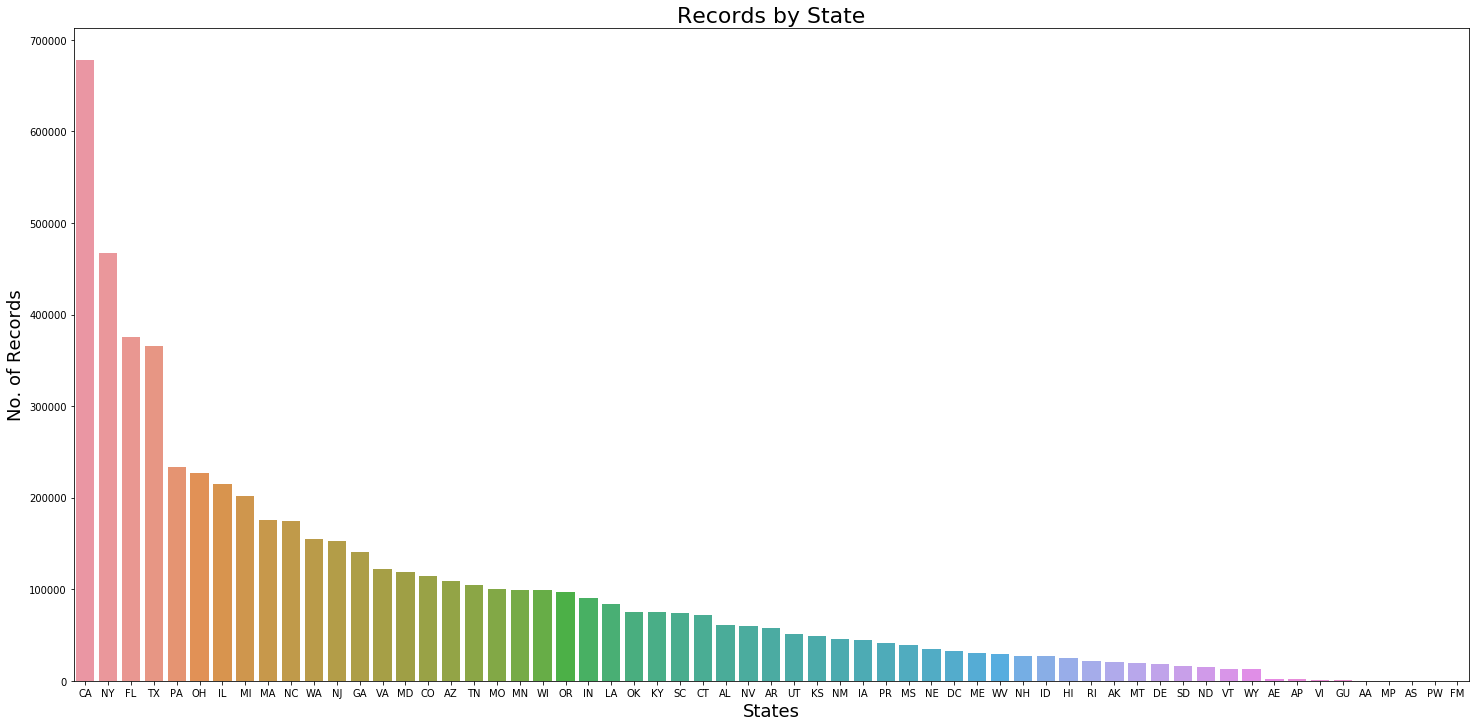

In [38]:
# Plot Record Count by State

plt.figure(figsize=(25,12))
sns.barplot(new_unique.index, new_unique.values)
plt.title('Records by State', fontsize=22)
plt.xlabel('States', fontsize=18)
plt.ylabel('No. of Records', fontsize=18)

This chart shows healthcare provider counts by each state. Here we can see the disparity in availability of providers for different states. States like CA, NY, FL have more than 350,000 providers whereas states like ND, VT, WY have fewer than 20,000 providers.

### Top 20 Taxonomy Codes (Specialities)

Taxonomy codes can be mapped to area of specialization using this [reference](http://www.wpc-edi.com/reference/codelists/healthcare/health-care-provider-taxonomy-code-set/). We can see that some of top specializations of healthcare providers in US include Physical Therapists, Pharmacists, Internal Medicine, Counselors, Social Workers, Family Medicine practitioners and so on.

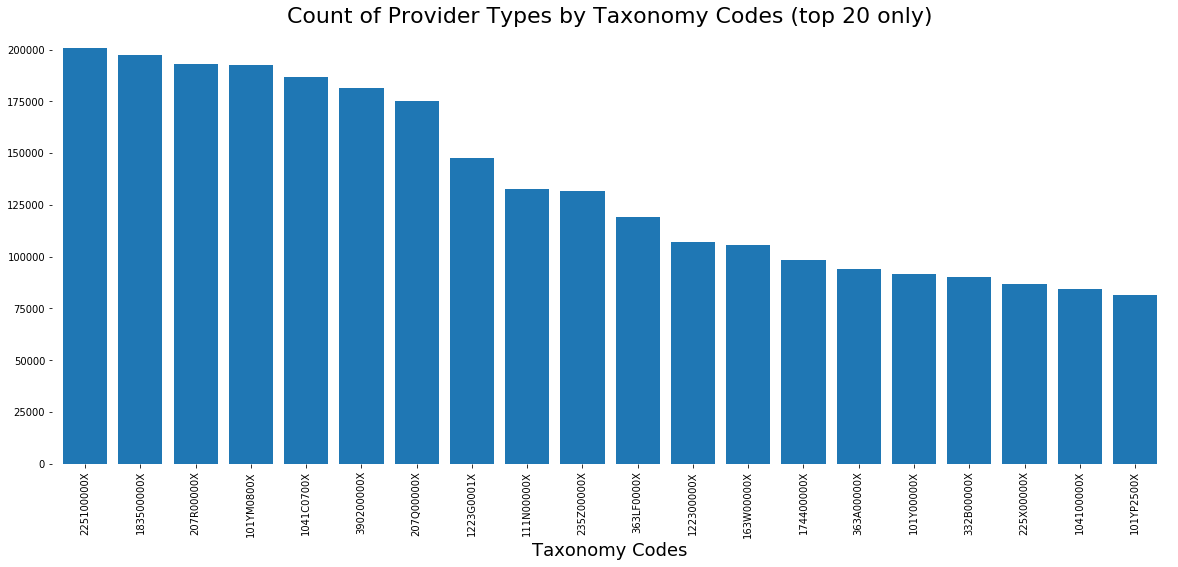

In [40]:
# Count of Provider Types
fig, ax = plt.subplots(figsize=(20,8))
# Add data
provider = npi_clean['taxonomy_code_1'].value_counts().reset_index()
ax.bar(provider.iloc[:20,0], provider.iloc[:20,1])
# Remove Spines
for key, spine in ax.spines.items():
    spine.set_visible(False)
# Adjust margin, ticks etc and add title    
ax.margins(0.01, 0)
ax.set_ylim(0,210000)
ax.set_title('Count of Provider Types by Taxonomy Codes (top 20 only)', fontsize=22)
ax.set_xlabel('Taxonomy Codes', fontsize=18)
plt.xticks(rotation=90)
# plt.tight_layout()
plt.show()

### Top 15 provider types for states with most and least providers

CA, NY, FL have the most providers whereas states like ND, VT, WY have the least. This chart clearly shows the disparity in availability of providers in the states with most vs states with least providers. Taxonomy codes can be mapped to area of specialization using this [reference](http://www.wpc-edi.com/reference/codelists/healthcare/health-care-provider-taxonomy-code-set/).

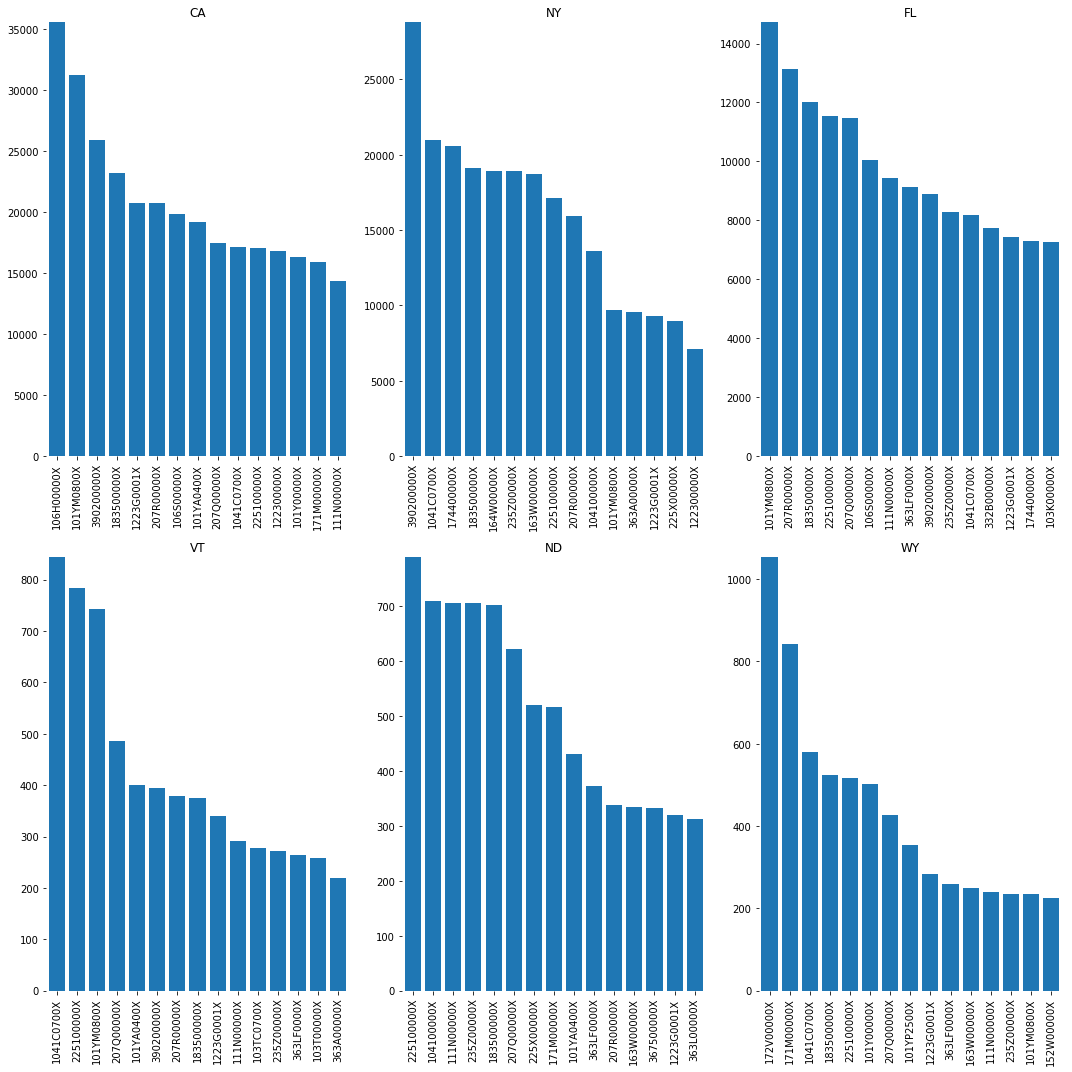

In [21]:
states = ['CA','NY','FL','VT','ND','WY']
fig = plt.figure(figsize=(15, 15))
for sp in range(0,6):
    ax = fig.add_subplot(2,3,sp+1)
    provType = npi_clean[npi_clean['state']==states[sp]]['taxonomy_code_1'].value_counts().reset_index()
    ax.bar(provType.iloc[:15,0], provType.iloc[:15,1])
    ax.set_title(states[sp])
    ax.set_ylim(0,provType.iloc[0,1])
    plt.xticks(rotation=90)
    for key, spine in ax.spines.items():
        spine.set_visible(False)
    ax.margins(0.01, 0)
plt.tight_layout() # automatically adjusts layout to fit long labels
plt.show()

### Count of Entity Types

We can see that most providers are individuals with fewer organizations. This looks right as an organization would have its own individual NPI but would have multiple individual providers working for them.

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


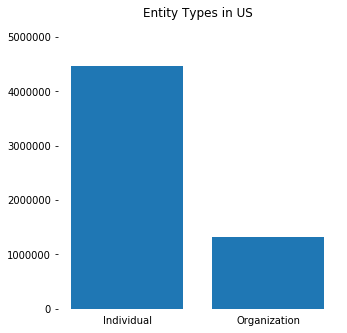

In [31]:
fig, ax = plt.subplots(figsize=(5,5))
entity = npi_clean['entity_type'].value_counts().reset_index()
ax.bar(entity.iloc[:,0], entity.iloc[:,1])
for key, spine in ax.spines.items():
    spine.set_visible(False)
ax.set_ylim(0,5000000)
ax.set_title('Entity Types in US', pad=20)
ax.tick_params(bottom="off")
plt.show()

## Export Data

In [143]:
# Removing records that are not a state in US
clean_statelist = ['NE', 'FL', 'NC', 'TX', 'CA', 'OH', 'NY', 'AZ', 'OK', 'MO', 'IL',
       'TN', 'MN', 'NV', 'GA', 'AL', 'IA', 'NJ', 'CT', 'MD', 'MI', 'WI',
       'NM', 'AR', 'PA', 'UT', 'KY', 'VA', 'IN', 'MS', 'ME', 'NH', 'MA',
       'MT', 'LA', 'CO', 'WV', 'WA', 'RI', 'OR', 'DC', 'KS', 'ID', 'SC',
       'HI', 'SD', 'DE', 'PR', 'AK', 'WY', 'VT', 'ND', 'AE', 'FM', 'VI',
       'GU', 'AP', 'PW', 'AA', 'AS', 'MP', 'FP', 'MH']

In [144]:
# Create csv files for each state
for stateName in clean_statelist:
    name = stateName
    i = npi_clean[npi_clean['state']==stateName]
    i.to_csv('npi_'+name+'.csv', index = None, header=True)

In [36]:
npi_clean.to_csv('npi_clean.csv', index=None, header=True)

In [4]:
import os
os.getcwd()

'C:\\Users\\mohi9282\\Desktop\\arcgis'

In [5]:
import os

In [7]:
output_path = os.path.join(os.getcwd(), "provider_clean_data2")
output_path

'C:\\Users\\mohi9282\\Desktop\\arcgis\\provider_clean_data2'

In [ ]:
# Create csv files for each state
for stateName in clean_statelist:
    name = stateName
    i = npi_clean[npi_clean['state']==stateName]
    file_name = os.path.join(output_path, 'npi_'+name+'.csv')
    i.to_csv(filename, index = None, header=True)

### Geocode

In [50]:
# Define function to geocode addresses
# def geocode_records(row):
#     geoAddress = geocode(row['Full_Address'])
#     row['Longitude'] = geoAddress[0]['location']['x']
#     row['Latitude'] = geoAddress[0]['location']['y']
#     return row

In [51]:
# # Apply geocode function
# ca_data = ca_data.apply(geocode_records, axis=1)

# # Check the dataset
# #ca_data.head()

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\dataframe\core.py:3121: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  warnings.warn(msg)


### Compute the dataframe

In [37]:
new_df = ca_data.compute()

In [38]:
new_df.shape

(249, 27)

In [39]:
new_df.describe()

,entity_type,taxonomy_code_10,taxonomy_code_11,taxonomy_code_12,taxonomy_code_13,taxonomy_code_14,taxonomy_code_15,taxonomy_code_1,taxonomy_code_2,taxonomy_code_3,taxonomy_code_4,taxonomy_code_5,taxonomy_code_6,taxonomy_code_7,taxonomy_code_8,taxonomy_code_9,taxonomy_group_1,NPI,city,country,postal_code,state,addressline1,provider_gender,organization_name,addressline2,full_address
count,50,0.0,0.0,0.0,0.0,0.0,0.0,50,8,4,2,1,1,1,0.0,0.0,1,50,50,50,50,50,50,44,6,25,249
unique,2,0.0,0.0,0.0,0.0,0.0,0.0,34,8,4,2,1,1,1,0.0,0.0,1,50,37,1,48,1,48,2,6,23,49
top,Individual,NaN,NaN,NaN,NaN,NaN,NaN,208000000X,207N00000X,207N00000X,207N00000X,207N00000X,207N00000X,207N00000X,NaN,NaN,193200000X MULTI-SPECIALTY GROUP,1821091836,SACRAMENTO,US,958211619,CA,600 COFFEE RD,F,"GENESIS HOME HEALTH, INC",SUITE 204,"nan, , nan, nan nan"
freq,44,NaN,NaN,NaN,NaN,NaN,NaN,4,1,1,1,1,1,1,NaN,NaN,1,1,4,50,2,50,2,33,1,2,199


In [39]:
export_csv = new_df.to_csv (r'C:\Users\mohi9282\Desktop\ca_export.csv', index = None, header=True)

### Plot on Map

In [333]:
sdf = pd.DataFrame.spatial.from_xy(new_df, x_column='Longitude', y_column='Latitude')

In [334]:
map1 = gis.map()
map1

MapView(layout=Layout(height='400px', width='100%'))

In [335]:
map1.draw(sdf.spatial.to_featureset())

In [119]:
!pip install graphviz

In [120]:
ca_data.visualize()

ExecutableNotFound: failed to execute ['dot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH

### Compute each state and create csv files

In [38]:
# Check unique value counts for each state
# unique_states = npi_updated['state'].value_counts().compute()
# unique_states
# Compute data for CA
# npi_ca = npi_updated[npi_updated['state']=='CA'].compute()
# Export CA data to csv
# export_ca = npi_ca.to_csv (r'C:\Users\mohi9282\Desktop\arcgis\clean_data\npi_ca.csv', index = None, header=True)
# npi_wy = npi_updated[npi_updated['state']=='WY'].compute()
# export_wy = npi_wy.to_csv(r'C:\Users\mohi9282\Desktop\arcgis\clean_data\npi_wy.csv', index = None, header=True)
# npi_tx.to_csv(r'C:\Users\mohi9282\Desktop\arcgis\clean_data\npi_tx.csv', index = None, header=True)